In [282]:
from madgwickahrs import * 
from quaternion import Quaternion
from conversion import * 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import norm
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


In [283]:
noisyIMU = True
short_len = 10000#15890

In [284]:
def conj(q):
    return [q[0], -q[1], -q[2], -q[3]]

def to_euler_angles(self):
    pitch = np.arcsin(2 * self[1] * self[2] + 2 * self[0] * self[3])
    if np.abs(self[1] * self[2] + self[3] * self[0] - 0.5) < 1e-8:
        roll = 0
        yaw = 2 * np.arctan2(self[1], self[0])
    elif np.abs(self[1] * self[2] + self[3] * self[0] + 0.5) < 1e-8:
        roll = -2 * np.arctan2(self[1], self[0])
        yaw = 0
    else:
        roll = np.arctan2(2 * self[0] * self[1] - 2 * self[2] * self[3], 1 - 2 * self[1] ** 2 - 2 * self[3] ** 2)
        yaw = np.arctan2(2 * self[0] * self[2] - 2 * self[1] * self[3], 1 - 2 * self[2] ** 2 - 2 * self[3] ** 2)
    return roll, pitch, yaw

## Real Data

In [285]:
# dt = 0.0001
# file_object  = open("trajectory_blender_20_0001.txt","r")

dt = 0.025
# file_object  = open("trajectory_blender_390_025.txt","r")
# file_object = open("trajectory_blender_80f_025.txt","r")
file_object = open("trajectory_penguin.txt","r")

px = []
py = []
pz = []
vx = []
vy = []
vz = []
time = []
Ax = []
Ay = []
Az = []

count = 0 
for i in file_object:
    if count > short_len: 
        pass
    else:
        sp = i.split()
        time.append(sp[0])
        px.append(float(sp[1]))
        py.append(float(sp[2]))
        pz.append(float(sp[3]))
        vx.append(float(sp[4]))
        vy.append(float(sp[5]))
        vz.append(float(sp[6]))
        Ax.append(float(sp[7]))
        Ay.append(float(sp[8]))
        Az.append(float(sp[9]))
    count = count + 1
    

print(len(Ax))



10001


## Noisy GPS

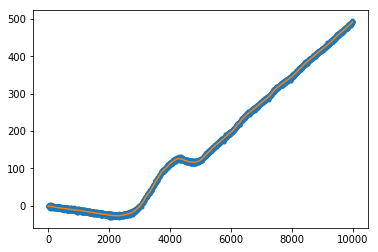

In [286]:
npx = []
npy = []
npz = []

wmp_GPS = 0 # meters, mean of the white noise measurement of position
wmv_GPS = 0 # meters / second, mean of the white noise measurement of velocity
wVp_GPS = 5#0.001 # meter^2, variance of the white noise measurement of position
wVv_GPS = .0004**2 # (4cm/s)**2 = .04**2 (m/s)^2, varaince of the white noise measurement of velocity

wNp_GPS = np.array([wmp_GPS,wVp_GPS])
wNv_GPS = np.array([wmv_GPS,wVv_GPS])

def get_noise_GPS_position():
    wp = np.asscalar(np.random.normal(wNp_GPS[0],np.sqrt(wNp_GPS[1]),1))
    return wp


    # returns the GPS noise for a given timestep
def get_measurement_noise_GPS():
    wv = np.asscalar(np.random.normal(wNv_GPS[0],np.sqrt(wNv_GPS[1]),1))
    wb = 0 # This the the extra zero padding, corresponding to the last term (bias) of the state dynamics
    return np.matrix([wp,wv,wb]).transpose()

    # [ p + n_p ]
    # [ v + n_p ]
    # [ 0 + bias ]
    # returns the current GPS measurement vector for the system
def get_measurement_GPS(i):
    return np.matrix([true_pos[i], true_vel[i],0]).transpose() + get_measurement_noise_GPS()



for i in range(len(px)):
    npx.append(px[i]+get_noise_GPS_position())
    npy.append(py[i]+get_noise_GPS_position())
    npz.append(pz[i]+get_noise_GPS_position())
    

plt.plot(npx,'.')
plt.plot(px)

rpx = px
rpy = py
rpz = pz

px = npx
py = npy
pz = npz


In [287]:
def calculateVelocity(p):
    vel = []
    for i in range(len(p)):
        if i == 0: 
            pass
        else: 
            vel.append((p[i]-p[i-1])/dt)
    return vel

def calculateAcceleration(v):
    acc = []
    for i in range(len(v)):
        if i ==0:
            pass
        else:
            acc.append((v[i]-v[i-1])/dt)
    return acc

# VX = calculateVelocity(px)
# AX = calculateAcceleration(vx)


def calculateVfromA(a, v0): 
    vel = []
    v = v0
    vel.append(v)
    for i in range(len(a)):
        v = v + a[i]*dt
        vel.append(v)
    
    return vel

def calculatePfromV(v, p0):
    pos = []
    p = p0
    pos.append(p)
    for i in range(len(v)):
        p = p + v[i]*dt
        pos.append(p)
        

    return pos



In [288]:
# vx0 = vx[0]
# vy0 = vy[0]
# vz0 = vz[0]

# px0 = px[0]
# py0 = py[0]
# pz0 = pz[0]


# print(px[0:10])

# print(vx[0:10])


# vX = calculateVfromA(Ax, vx0)

# print(vX[0:10])

[0.47448316624811115, -0.6726547228844956, -1.6030910636877405, -0.09493154836380224, 2.0178098091523538]
[-0.343448168344, -0.344086090682, -0.345057743037, -0.346409907895, -0.348180413287]
[-0.343448168344, -0.343937058451905, -0.34473330251188, -0.34588816024185, -0.34744393690046]


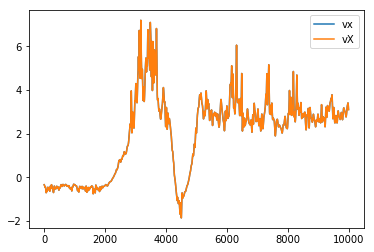

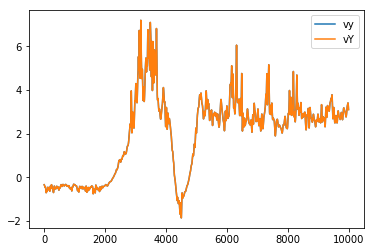

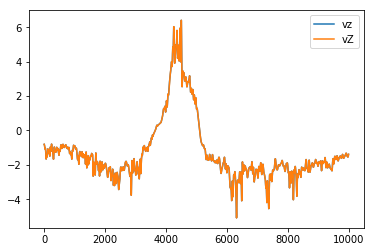

0.47448316624811115
0.47448316624811115
9.161418659157983
9.161418659157983


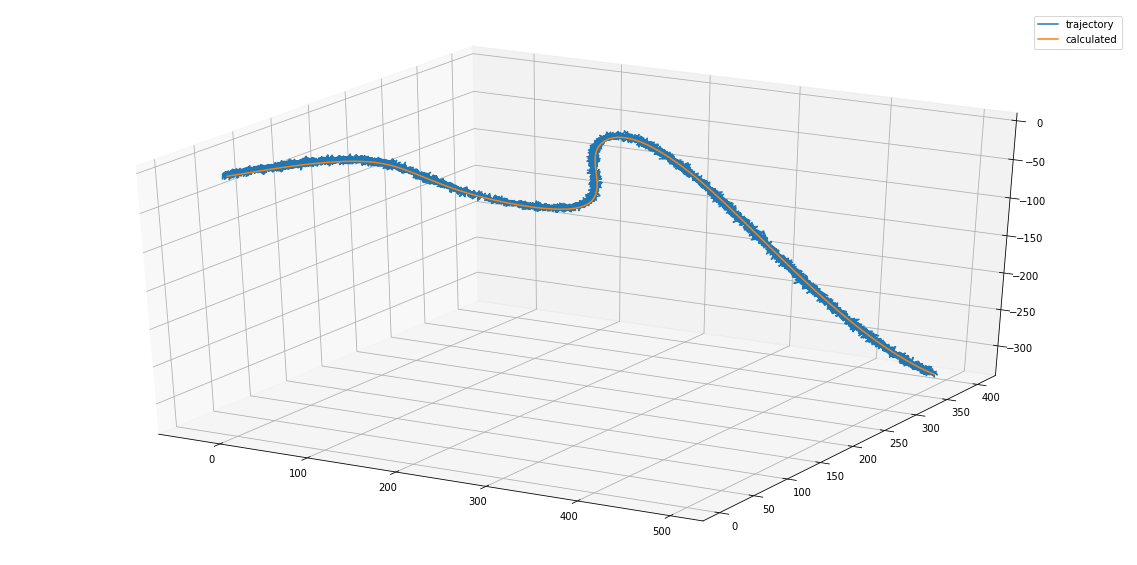

In [289]:
vx0 = vx[0]
vy0 = vy[0]
vz0 = vz[0]

px0 = px[0]
py0 = py[0]
pz0 = pz[0]


print(px[0:5])

print(vx[0:5])


vX = calculateVfromA(Ax, vx0)

print(vX[0:5])
vY = calculateVfromA(Ay, vy0)
vZ = calculateVfromA(Az, vz0)
plt.plot(vx)
plt.plot(vX)
plt.legend(["vx", "vX"])
plt.show()
plt.plot(vx)
plt.plot(vX)
plt.legend(["vy", "vY"])
plt.show()
plt.plot(vz)
plt.plot(vZ)
plt.legend(["vz", "vZ"])
plt.show()


pX = calculatePfromV(vX, px0)
pY = calculatePfromV(vY, py0)
pZ = calculatePfromV(vZ, pz0)
# plt.plot(px)
# plt.plot(pX)
# plt.show()
# plt.plot(py)
# plt.plot(pY)
# plt.show()
# plt.plot(pz)
# plt.plot(pZ)
# plt.show()
    
print(px[0])
print(pX[0])
print(py[0])
print(pY[0])
    
fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.plot(px, py, pz, label='trajectory')
axplot.plot(pX, pY, pZ, label='calculated')
axplot.legend()

plt.show()


    
# def calculateVelocityfromAcceleration(a): 
    

## IMU Data

In [290]:
# file_object = open("imu_values_blender_20_0001.txt","r")
# file_object = open("imu_values_blender_390_025.txt","r")
# file_object = open("imu_values_blender_80f_025.txt","r")
file_object = open("imu_values_penguin.txt","r")


ax = []
ay = []
az = []
gx = []
gy = []
gz = []
magx = []
magy = []
magz = []

count = 0
for i in file_object:
    if count > short_len:
        pass
    else: 
        sp = i.split()
        ax.append(float(sp[1]))
        ay.append(float(sp[2]))
        az.append(float(sp[3]))
        gx.append(float(sp[4]))
        gy.append(float(sp[5]))
        gz.append(float(sp[6]))
        magx.append(float(sp[7]))
        magy.append(float(sp[8]))
        magz.append(float(sp[9]))
    count = count + 1

print(ax[0:10])
    


[-0.0654213757585, -0.0799577185893, -0.0961961919434, -0.113776528328, -0.132338669957, -0.151522199037, -0.170966909466, -0.190312519873, -0.209198730822, -0.227265224572]


## Noisy IMU

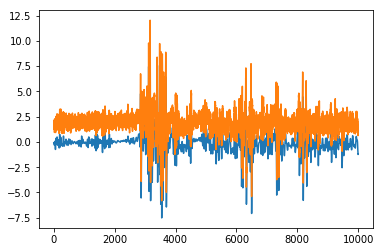

[1.8564601814828676, 1.6191176670522633, 1.965340957892356, 2.018327961014098, 2.132790926418468, 1.7219475216916735, 1.8247643016398074, 2.134211358274222, 2.0623757326681567, 1.9631340551852827]


In [291]:
if noisyIMU: 
    nax = []
    nay = []
    naz = []
    ngx = []
    ngy = []
    ngz = []

    # white gaussian noise with zero mean and variance = 0.0004
    wV_Accel = .0004 # Accelerometer white noise variance 
    wm_Accel = 1 # Accelerometer white noise mean
    wN_Accel = np.array([wm_Accel, wV_Accel])

    # bias with a priori statistics b_a ~ N(0,0.01)
    bu_Accel = 1 # Mean of bias term
    bV_Accel = .1 # Variance of bias (m/s^2)^2
    bN_Accel = np.array([bu_Accel, bV_Accel])

    def get_white_noise_accelerometer():
        return np.asscalar(np.random.normal(wN_Accel[0],np.sqrt(wN_Accel[1]),1))
        #return 0

    def set_bias_accelerometer():
        return np.asscalar(np.random.normal(bN_Accel[0], np.sqrt(bN_Accel[1]),1))
        #return 0 

        # a = a + w + b
    def get_accelerometer_reading(a, white_noise):
        return a + white_noise + bu_Accel

    for i in range(len(ax)): 
        nax.append(ax[i]+get_white_noise_accelerometer() + set_bias_accelerometer())
        nay.append(ay[i]+get_white_noise_accelerometer() + set_bias_accelerometer())
        naz.append(az[i]+get_white_noise_accelerometer() + set_bias_accelerometer())
        ngx.append(gx[i]+get_white_noise_accelerometer() + set_bias_accelerometer())
        ngy.append(gy[i]+get_white_noise_accelerometer() + set_bias_accelerometer())
        ngz.append(gz[i]+get_white_noise_accelerometer() + set_bias_accelerometer())


    plt.plot(ax)
    plt.plot(nax)
#     plt.plot(ay)
#     plt.plot(nay)
#     plt.plot(az)
#     plt.plot(naz)
    plt.show()


    ax = nax
    ay = nay
    az = naz 

    gx = ngx
    gy = ngy
    gz = ngz
    print(nax[0:10])

In [292]:
Acc = np.hstack([np.array(ax)[np.newaxis].T, np.array(ay)[np.newaxis].T, np.array(az)[np.newaxis].T])
Gyro = np.hstack([np.array(gx)[np.newaxis].T, np.array(gy)[np.newaxis].T, np.array(gz)[np.newaxis].T])
Mag = np.hstack([np.array(magx)[np.newaxis].T, np.array(magy)[np.newaxis].T, np.array(magz)[np.newaxis].T])


In [293]:
print(ax[0])
print(ay[0])
print(az[0])

1.8564601814828676
1.5290549716729198
-8.301172353976431


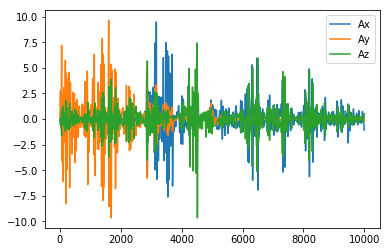

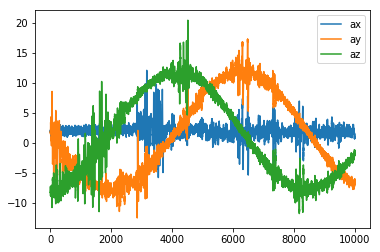

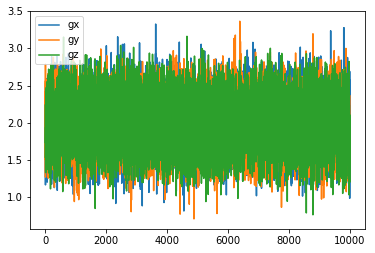

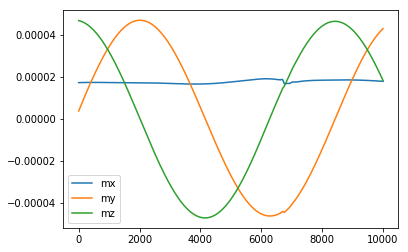

In [294]:
plt.plot(Ax)
plt.plot(Ay)
plt.plot(Az)
plt.legend(["Ax","Ay","Az"])
plt.show()
plt.plot(ax)
plt.plot(ay)
plt.plot(az)
plt.legend(["ax","ay","az"])
plt.show()
plt.plot(gx)
plt.plot(gy)
plt.plot(gz)
plt.legend(["gx","gy","gz"])
plt.show()
plt.plot(magx)
plt.plot(magy)
plt.plot(magz)
plt.legend(["mx","my","mz"])
plt.show()


In [295]:
## TODO:  yprchange
rollrate = np.array(gx)
pitchrate = np.array(gy)
yawrate = np.array(gz)
print(len(rollrate))

10001


## AHRS

In [296]:

sampleperiod = dt

rot_mat = []
Imupredict = MadgwickAHRS()
Imupredict.sampleperiod = sampleperiod
roll = []
pitch = []
yaw = []

for i in range(len(ax)):
    #Imupredict.update(Gyro[i], Acc[i], Mag[i])
    Imupredict.update_imu(Gyro[i], Acc[i])
    q = Imupredict.quaternion
#     rot_mat.append( np.transpose(quaterniontorotmatrix(q)))

    rot_mat.append( quaterniontorotmatrix(q))

    q1 = conj(q)
    q2 = to_euler_angles(q1)
    roll.append(q2[0])
    pitch.append(q2[1])
    yaw.append(q2[2])
#     roll.append(q2[0]*180/math.pi)
#     pitch.append(q2[1]*180/math.pi)
#     yaw.append(q2[2]*180/math.pi)
    
#     print(np.transpose(quaterniontorotmatrix(q)))



In [297]:
# rot_mat = []

# for i in range(len(ax)):
#     rot_mat.append(np.mat([[1,0,0],[0,1,0],[0,0,1]]))


In [298]:
Earth_acc = []
Ex = []
Ey = []
Ez = []
for i in range(len(Acc)):
    Earth_acc.append(rot_mat[i]*np.transpose([Acc[i]]))
    mat = np.array(rot_mat[i]*np.transpose([Acc[i]]))
#     print(mat[0][0], mat[1][0], mat[2][0])
    Ex.append(mat[0][0])
    Ey.append(mat[1][0])
    Ez.append(mat[2][0])

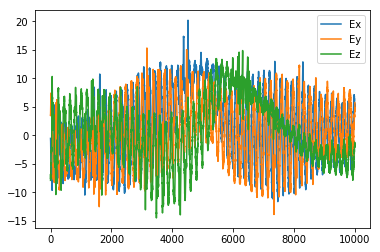

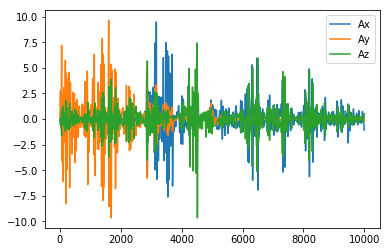

[2.382187086348095, 1.9118847845484785]
[-0.5293387925200808, -0.6755934755064138]
[-0.0195556043162, -0.031849762399]
[3.501009579919207, 3.451283696492965]
[0.20326977377, 0.329964825542]
[-7.883948777503504, -6.794188613743409]
[-0.0451315614171, -0.0741615025773]


In [299]:

plt.plot(Ex)
# plt.plot(ax)
plt.plot(Ey)
# plt.plot(ay)
# plt.show()
plt.plot(Ez)
# plt.plot(az)
plt.legend(["Ex","Ey","Ez"])
plt.show()

plt.plot(Ax)
plt.plot(Ay)
plt.plot(Az)
plt.legend(["Ax","Ay","Az"])
plt.show()


print(gx[0:2])
print(Ex[0:2])
print(Ax[0:2])
print(Ey[0:2])
print(Ay[0:2])
print(Ez[0:2])
print(Az[0:2])

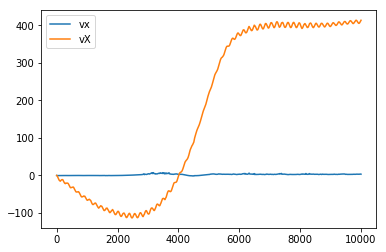

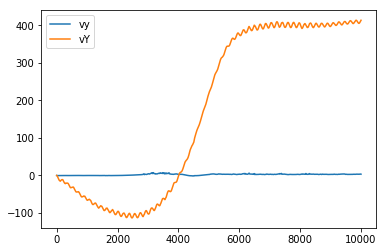

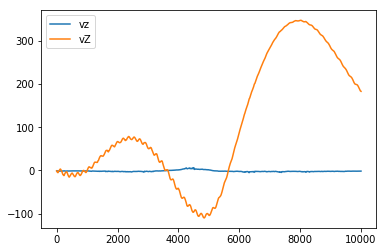

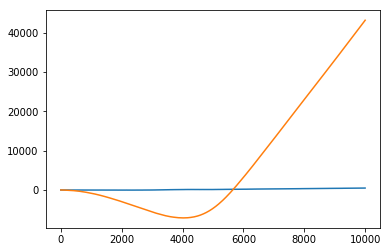

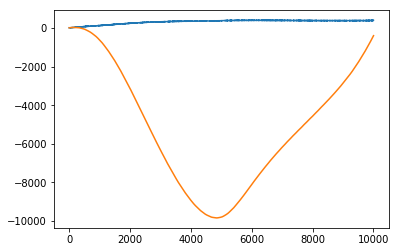

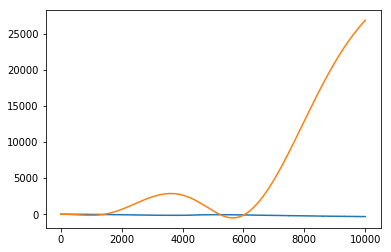

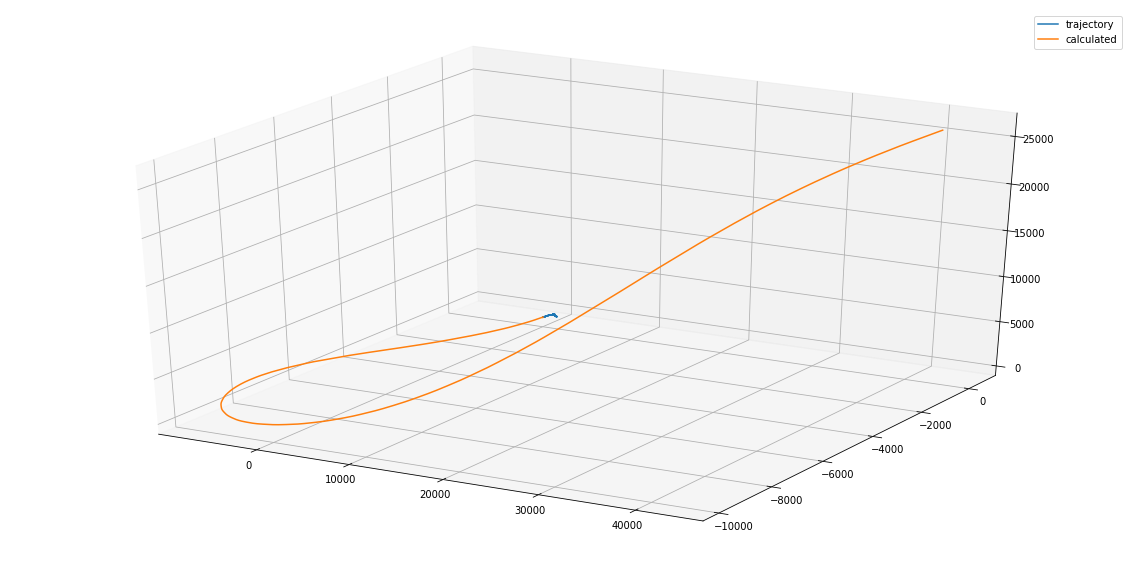

In [300]:
vX = calculateVfromA(Ex, vx0)
vY = calculateVfromA(Ey, vy0)
vZ = calculateVfromA(Ez, vz0)
plt.plot(vx)
plt.plot(vX)
plt.legend(["vx", "vX"])
plt.show()
plt.plot(vx)
plt.plot(vX)
plt.legend(["vy", "vY"])
plt.show()
plt.plot(vz)
plt.plot(vZ)
plt.legend(["vz", "vZ"])
plt.show()


pX = calculatePfromV(vX, px0)
pY = calculatePfromV(vY, py0)
pZ = calculatePfromV(vZ, pz0)
plt.plot(px)
plt.plot(pX)
plt.show()
plt.plot(py)
plt.plot(pY)
plt.show()
plt.plot(pz)
plt.plot(pZ)
plt.show()
    
    
fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.plot( px, py, pz, label='trajectory')
axplot.plot( pX, pY, pZ, label='calculated')
axplot.legend()

plt.show()

# plt.plot(px,py)
# plt.plot(pX,pY)

# print(px[0])
# print(py[0])

# print(pX[0])
# print(pY[0])

In [301]:

numstates = 8

# Kalman Filter Design

In [302]:
print(max(Ax))
print(max(Ay))
print(max(rollrate)*180/np.pi) #gx in rad/s
print(max(pitchrate)) #gy in rad/s
print(max(yawrate)) #gz in rad/s

9.4716742146
9.63977821364
190.58373046500387
3.3639410380569457
3.161875310038326


## Q: Process Noise

In [303]:
jerkmax = 300.0    # m/s3
pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2

Q = np.diagflat([[(dt * jerkmax)/1000],            # acceleration
                 [(dt * jerkmax)/1000],            # acceleration
            [(dt * yawrateaccmax)/1000],           # yawrate
            [(dt * pitchrateaccmax)/1000],         # pitchrate
            [(dt * rollrateaccmax)/1000]])         # rollrate





# Q = np.diagflat([[6],            # acceleration
#             [6],
#             [(0.028)**2],           # yawrate
#             [(0.070)**2],         # pitchrate
#             [(0.070)**2]])         # rollrate

In [304]:
rdx = []
rdy = []
rdz = []


for i in range(len(rpx)):
    if i ==0:
        rdx.append(0)
        rdy.append(0)
        rdz.append(0)
    else:
        rdx.append(rpx[i]-rpx[i-1])
        rdy.append(rpy[i]-rpy[i-1])
        rdz.append(rpz[i]-rpz[i-1])

        
print(rdx[0:5])


rmx = np.cumsum(rdx)
rmy = np.cumsum(rdy)
rmz = np.cumsum(rdz)


real_mx = rmx
real_my = rmy 
real_mz = rmz 


[0, -0.008593537605999901, -0.008613550499000033, -0.008642510077999987, -0.008681473975000076]


[0, -1.1471378891326067, -0.9304363408032449, 1.5081595153239382, 2.112741357516156]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


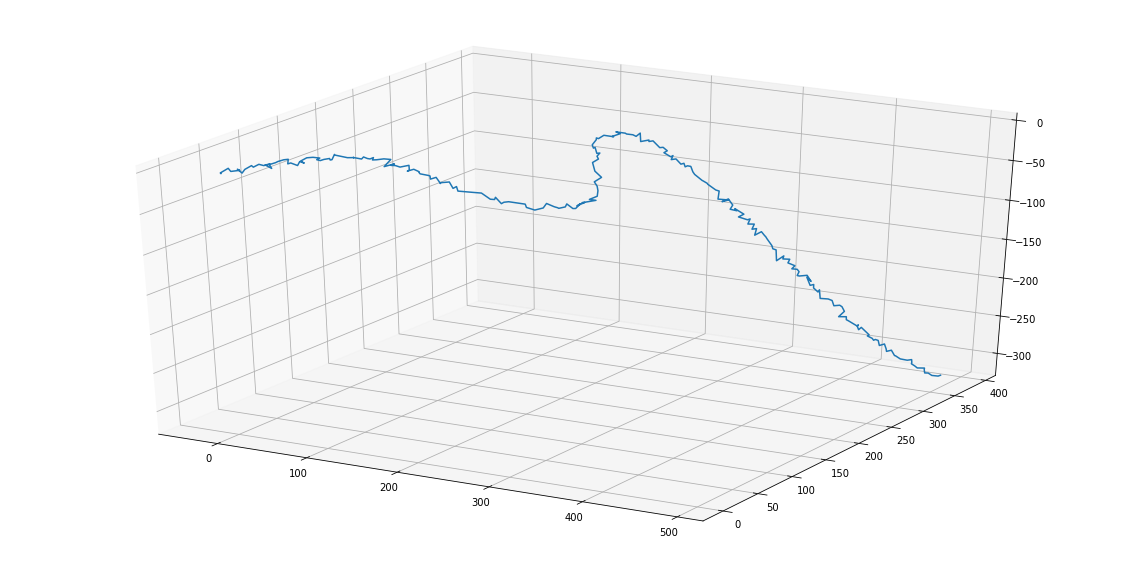

In [305]:
dx = []
dy = []
dz = []


for i in range(len(px)):
    if i ==0:
        dx.append(0)
        dy.append(0)
        dz.append(0)
    else:
        dx.append(px[i]-px[i-1])
        dy.append(py[i]-py[i-1])
        dz.append(pz[i]-pz[i-1])

        
print(dx[0:5])


mx = np.cumsum(dx)
my = np.cumsum(dy)
mz = np.cumsum(dz)


# real_mx = mx
# real_my = my 
# real_mz = mz 


count = 0
mx2 = []
storex = 0
my2 = []
storey = 0
mz2 = []
storez = 0
for i in range(len (mx)):
    if count == 0:
        storex = mx[i]
        storey = my[i]
        storez = mz[i]
        mx2.append(storex)
        my2.append(storey)
        mz2.append(storez)
        count = 40
    else: 
        mx2.append(storex)
        my2.append(storey)
        mz2.append(storez)
        count = count -1 
        
print(mx2[0:5])
print(my2[0:5])
print(mz2[0:5])

mx = mx2
my = my2
mz = mz2


    


ds = np.sqrt(np.array(dx)**2 + np.array(dy)**2 + np.array(dz)**2)

# print(np.diff(ds[0:500]))
# GPS = ds.astype('bool')

GPS=np.hstack((True, (abs(np.diff(ds))>0.0).astype('bool'))) # GPS Trigger for Kalman Filter

# print(len(px))
# print(len(ax))
# print(len(dx))
# print(len(mx))
# print(len(GPS))
# print(dx[0:5])
# print(mx[0:5])

# print(np.diff(ds))
# print(np.diff(ds)<0)

    
fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.plot(mx, my, mz)
# axplot.plot(mx2, my2, mz2)


plt.show()

In [306]:
print(len(GPS))
print(len(np.where(GPS)[0]))

10001
10001


In [307]:
# dx = []
# dy = []
# dz = []
# for i in range(len(px)):
#     if i ==0:
#         dx.append(0)
#         dy.append(0)
#         dz.append(0)
#     else:
#         dx.append(px[i]-px[i-1])
#         dy.append(py[i]-py[i-1])
#         dz.append(pz[i]-pz[i-1])


# mx = np.cumsum(dx)
# my = np.cumsum(dy)
# mz = np.cumsum(dz)

# ds = np.sqrt(np.array(dx)**2 + np.array(dy)**2 + np.array(dz)**2)

# GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter
# # print(len(px))
# # print(len(ax))
# # print(len(dx))
# # print(len(mx))
# # print(len(GPS))
# # print(dx[0:5])
# # print(mx[0:5])

    
# fig = plt.figure(figsize=(20,10))
# axplot = fig.gca(projection='3d')
# axplot.plot(mx, my, mz)
# axplot.legend()

# plt.show()

In [308]:
print(max(dx))
print(max(dy))
print(max(dz))
print(min(dz))
print(min(vx))
print(max(vy))
print(min(pitch))
print(max(pitch))
print(min(pitchrate))
print(max(pitchrate))

12.826877967854399
11.058176304428116
11.343985151882904
-12.793794719093427
-1.86342636247
7.34296908685
-1.1509657062923477
1.5559201058321668
0.7109584797384292
3.3639410380569457


## R: Measurement Noise Covariance
## TODO: R could be different

In [309]:
R = np.diagflat([[(0.0004)**2],      # x
            [(0.0004)**2],           # y
            [(0.0004)**2],           # z
            [(0.001)**2],  # vx
            [(0.001)**2],
            [(0.005)**2],  # heading 
            [(0.005)**2],  # pitch
            [(0.005)**2]]) # roll


# R = np.diagflat([[(5.0)**2],      # x
#             [(5.0)**2],           # y
#             [(5.0)**2],           # y
#             [(10.0)**2],  # v
#             [(10.0)**2],  # v
#             [(0.5)**2],  # heading 
#             [(0.5)**2],  # pitch
#             [(0.5)**2]]) # roll

In [310]:
# speed = np.array(vx)
# print(len(vx))
# print(len(ax))

In [311]:
## Change these values 

In [312]:
# epe = (np.zeros(np.shape(ax))+1)*3

# epsilon = 0.1
# xi      = 500.0
# zeta    = 50.0
# spspeedx=xi/((np.array(vx)/1.0)+epsilon)
# spspeedy=xi/((np.array(vy)/1.0)+epsilon)

# spepe=zeta*epe
# spx = (spspeedx)**2 + (spepe)**2
# spy = (spspeedy)**2 + (spepe)**2


# print(spspeedx)
# print(spspeedy)
# print(spx)
# print(spy)



In [313]:
az = np.array(az)
ax = np.array(ax)
ay = np.array(ay)

rho = 200.0
gamma=500.0

sroll = (rho + gamma*ay)**2
spitch= (rho + gamma*ax)**2
syaw = (rho + gamma*az)**2

print(sroll)
print(spitch)

[  930313.270934     987066.8466995    999001.48687559 ...
  8701733.43900266 11400578.82962096 11498502.66376433]
[1272903.13765442 1019209.03835064 1398709.46177078 ...  321749.24699744
  416359.21085799  363360.71737172]


## I

In [314]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]] (8, 8)


In [315]:
vxs, vys, vzs, psis, dpsis, dts, xs, ys, zs, axs, ays, azs, phis, dphis, thetas, dthetas, Lats, Lons = \
 symbols('v_x, v_y, v_z \psi \dot\psi T x y z a_x, a_y, a_z, \phi \dot\phi \Theta \dot\Theta Lat Lon')

As = Matrix([[xs+(vxs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+((vxs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))) + ((vys/dphis)*(sin(phis+dphis*dts)-sin(phis)))],
             [zs+(vys/dphis)*(-cos(phis+dphis*dts)+cos(phis))],
             [vxs + axs*dts],
             [vys + ays*dts],
             [psis+dpsis*dts],
             [thetas+dthetas*dts],
             [phis+dphis*dts]])
state = Matrix([xs,ys,zs,vxs,vys,psis,thetas,phis])

In [316]:
As

⎡                         vₓ⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))            
⎢                     x + ────────────────────────────────────────            
⎢                                         \dot\psi                            
⎢                                                                             
⎢    vₓ⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))   v_y⋅(-sin(\phi) + sin(T⋅\dot\ph
⎢y + ─────────────────────────────────────── + ───────────────────────────────
⎢                    \dot\psi                                   \dot\phi      
⎢                                                                             
⎢                         v_y⋅(cos(\phi) - cos(T⋅\dot\phi + \phi))            
⎢                     z + ────────────────────────────────────────            
⎢                                         \dot\phi                            
⎢                                                                             
⎢                                       T⋅aₓ + vₓ   

In [317]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  z   ⎥
⎢      ⎥
⎢  vₓ  ⎥
⎢      ⎥
⎢ v_y  ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢\Theta⎥
⎢      ⎥
⎣ \phi ⎦

## Jacobian of dynamic matrix with respect to state

In [318]:
As.jacobian(state)

⎡         -sin(\psi) + sin(T⋅\dot\psi + \psi)                                 
⎢1  0  0  ───────────────────────────────────                   0             
⎢                       \dot\psi                                              
⎢                                                                             
⎢         cos(\psi) - cos(T⋅\dot\psi + \psi)   -sin(\phi) + sin(T⋅\dot\phi + \
⎢0  1  0  ──────────────────────────────────   ───────────────────────────────
⎢                      \dot\psi                              \dot\phi         
⎢                                                                             
⎢                                              cos(\phi) - cos(T⋅\dot\phi + \p
⎢0  0  1                   0                   ───────────────────────────────
⎢                                                           \dot\phi          
⎢                                                                             
⎢0  0  0                   1                        

## Control input

In [319]:
control = Matrix([axs, ays, dpsis, dthetas,dphis ])
control

⎡    aₓ    ⎤
⎢          ⎥
⎢   a_y    ⎥
⎢          ⎥
⎢ \dot\psi ⎥
⎢          ⎥
⎢\dot\Theta⎥
⎢          ⎥
⎣ \dot\phi ⎦

## Jacobian of the Dynamic Matirx with respect to the control input

In [320]:
JGs = As.jacobian(control)
JGs

⎡      T⋅vₓ⋅cos(T⋅\dot\psi + \psi)   vₓ⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi)) 
⎢0  0  ─────────────────────────── - ──────────────────────────────────────── 
⎢                \dot\psi                                   2                 
⎢                                                   \dot\psi                  
⎢                                                                             
⎢      T⋅vₓ⋅sin(T⋅\dot\psi + \psi)   vₓ⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))  
⎢0  0  ─────────────────────────── - ───────────────────────────────────────  
⎢                \dot\psi                                   2                 
⎢                                                   \dot\psi                  
⎢                                                                             
⎢                                                                             
⎢0  0                                    0                                    
⎢                                                   

In [321]:
hs = Matrix([[xs],[ys],[zs],[vxs],[vys],[psis],[thetas],[phis]])
Hs=hs.jacobian(state)
Hs

⎡1  0  0  0  0  0  0  0⎤
⎢                      ⎥
⎢0  1  0  0  0  0  0  0⎥
⎢                      ⎥
⎢0  0  1  0  0  0  0  0⎥
⎢                      ⎥
⎢0  0  0  1  0  0  0  0⎥
⎢                      ⎥
⎢0  0  0  0  1  0  0  0⎥
⎢                      ⎥
⎢0  0  0  0  0  1  0  0⎥
⎢                      ⎥
⎢0  0  0  0  0  0  1  0⎥
⎢                      ⎥
⎣0  0  0  0  0  0  0  1⎦

## Initial State

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.34344817]
 [ 3.55934521]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] (8, 1)


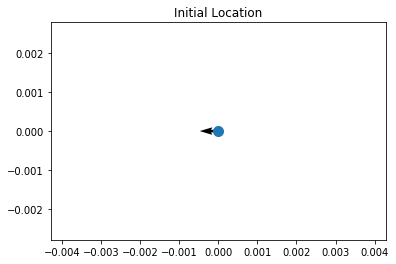

In [322]:
x = np.matrix([[mx[0], my[0], mz[0], vx[0]/1.0, vy[0]/1.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

U=float(np.cos(x[5])*x[3])
V=float(np.sin(x[5])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

## Initial Uncertainty

In [323]:
## TODO: see how this value changes the result
P = 1e-4*np.eye(numstates)
print(P)

# P = np.array([[1e-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
#               [0.0,1e-4,0.0,0.0,0.0,0.0,0.0,0.0],
#               [0.0,0.0,1e-4,0.0,0.0,0.0,0.0,0.0],
#               [0.0,0.0,0.0,1e-4,0.0,0.0,0.0,0.0],
#               [0.0,0.0,0.0,0.0,1e-4,0.0,0.0,0.0],
#               [0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0],
#               [0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0],
#               [0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0]])

print(P)
    

[[0.0001 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0001 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0001]]
[[0.0001 0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.0001 0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0001 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0001]]


## Measurement Vector

In [324]:
mx = np.array(mx)
my = np.array(my)
mz = np.array(mz)

vx = np.array(vx)
vy = np.array(vy)
yaw = np.array(yaw)
pitch = np.array(pitch)
roll = np.array(roll)

measurements = np.vstack((mx, my, mz, \
                          vx/1.0, \
                          vy/1.0, \
                          yaw, \
                          pitch, \
                          roll))

# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(8, 10001)


In [325]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
Zx = []
Zy = []
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []
K0 = []
K1 = []
K2 = []
K3 = []
K4 = []
K5 = []
K6 = []
K7 = []
dstate=[]

h0 = []
h1 = []
h2 = []

In [326]:
print(mx[0])
print(my[0])
print(mz[0])
print(x[0])
print(x[1])
print(x[2])
print(measurements[0])
print(m)
ri = short_len
x0.append(float(x[0]))
x1.append(float(x[1]))
x2.append(float(x[2]))
print(x0)
print(x1)
print(x2)
h0.append(x[0])
h1.append(x[1])
h2.append(x[2])

0.0
0.0
0.0
[[0.]]
[[0.]]
[[0.]]
[  0.           0.           0.         ... 489.11830328 489.11830328
 489.11830328]
10001
[0.0]
[0.0]
[0.0]


In [327]:

for filterstep in range(ri):

    axc = ax[filterstep]
    ayc = ay[filterstep]
    yawc = yawrate[filterstep]
    pitc = pitchrate[filterstep]
    rolc = rollrate[filterstep]    
    
#     print("old")
#     print(x[0])
#     print(x[1])
#     print(x[2])
    
    if yawc==0.0: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[5])
        x[1] = x[1] + x[3]*dt * np.sin(x[5]) + x[4]*dt * np.cos(x[7])  
        x[2] = x[2] + x[4]*dt * np.sin(x[7])
        x[3] = x[3] + axc*dt
        x[4] = x[4] + ayc*dt
        x[5] = x[5] + yawc*dt
        x[6] = x[6] + pitc*dt
        x[7] = x[7] + rolc*dt
        yawc = 0.00000001 # to avoid numerical issues in Jacobians
        rolc = 0.00000001 # to avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5]))
        x[1] = x[1] + ((x[3]/yawc) * (-np.cos(yawc*dt+x[5])+ np.cos(x[5]))) + ((x[4]/rolc) * (np.sin(rolc*dt+x[7])- np.sin(x[7])))
        x[2] = x[2] + ((x[4]/rolc) * (-np.cos(rolc*dt+x[7])+ np.cos(x[7])))
        x[3] = x[3] + axc*dt
        x[4] = x[4] + ayc*dt
        x[4] = (x[4] + yawc*dt + np.pi) % (2.0*np.pi) - np.pi
        x[5] = x[5] + pitc*dt
        #x[6] = x[6] + rolc*dt
        x[6] = (x[6] + rolc*dt + np.pi) % (2.0*np.pi) - np.pi
        dstate.append(1)
#     print("predicted")
#     print(x[0]) 
#     print(x[1])
#     print(x[2])
    
    
    a14 = float((1.0/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5])))
    a16 = float((x[3]/yawc)* (np.cos(yawc*dt+x[5]) - np.cos(x[5])))
    a24 = float((1.0/yawc) * (-np.cos(yawc*dt+x[5]) + np.cos(x[5])))
    a25 = float((1.0/rolc) * (np.sin(rolc*dt+x[7]) - np.sin(x[7])))
    a26 = float((x[3]/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5])))
    a28 = float((x[4]/rolc)* (np.cos(rolc*dt+x[7]) - np.cos(x[7])))
    a35 = float((1/rolc)* (-np.cos(rolc*dt+x[7]) + np.cos(x[7])))
    a38 = float((x[4]/rolc)* (np.sin(rolc*dt+x[7]) - np.sin(x[7])))

    JA = np.matrix([[1.0, 0.0, 0.0, a14, 0.0, a16, 0.0, 0.0],
                  [0.0, 1.0, 0.0, a24, a25, a26, 0.0, a28],
                  [0.0, 0.0, 1.0, 0.0, a35, 0.0, 0.0, a38],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
#     print(np.shape(JA))
    
    
    g13 = float((dt*x[3]/yawc)*np.cos(yawc*dt+x[5]) - (x[3]/yawc**2)*(np.sin(yawc*dt+x[5])-np.sin(x[5])))
    g23 = float((dt*x[3]/yawc)*np.sin(yawc*dt+x[5]) - (x[3]/yawc**2)*(-np.cos(yawc*dt+x[5])+np.cos(x[5])))
    g25 = float((dt*x[4]/rolc)*np.cos(rolc*dt+x[7]) - (x[4]/rolc**2)*(np.sin(rolc*dt+x[7])-np.sin(x[7])))
    g35 = float((dt*x[4]/rolc)*np.sin(rolc*dt+x[7]) - (x[4]/yawc**2)*(-np.cos(rolc*dt+x[7])+np.cos(x[7])))
                
    JG = np.matrix([[0.0, 0.0, g13, 0.0, 0.0],
                    [0.0, 0.0, g23, 0.0, g25],
                    [0.0, 0.0, 0.0, 0.0, g35],
                    [dt, 0.0, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 0.0, dt]])
    
    # Project the error covariance ahead
    P = JA*P*JA.T + JG*Q*JG.T
    
#     print("predicted P")
#     print(P)
    
    
    # Measurement Update (Correction)
    # ===============================
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])],
                    [float(x[6])],
                    [float(x[7])]])
    # Because GPS is sampled with 10Hz and the other Measurements, as well as
    # the filter are sampled with 50Hz, one have to wait for correction until
    # there is a new GPS Measurement
    if GPS[filterstep]:
        #print("GPS")
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        S = JH*P*JH.T + R    # R should be small and S should be small 
        K = (P*JH.T) * np.linalg.inv(S)

        # Update the estimate via
        z = measurements[:,filterstep].reshape(JH.shape[0],1)
        y = z - (hx)                         # Innovation or Residual
        x = x + (K*y)

        h0.append(z[0])
        h1.append(z[1])
        h2.append(z[2])

        #     # Update the error covariance
        P = (I - (K*JH))*P



#     else: 
#         JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

#     S = JH*P*JH.T + R    # R should be small and S should be small 
#     K = (P*JH.T) * np.linalg.inv(S)

#     # Update the estimate via
#     z = measurements[:,filterstep].reshape(JH.shape[0],1)
#     y = z - (hx)                         # Innovation or Residual
#     x = x + (K*y)

#     h0.append(z[0])
#     h1.append(z[1])
#     h2.append(z[2])

#     #     # Update the error covariance
#     P = (I - (K*JH))*P


#     else:



    

    
# #     # Adaptive R
#     R[0,0] = spx[filterstep]       # x
#     R[1,1] = spy[filterstep]       # y
#     R[2,2] = spy[filterstep]
#     R[3,3] = spspeedx[filterstep]  # vx
#     R[4,4] = spspeedy[filterstep]
#     R[5,5] = syaw[filterstep]  # course
#     R[6,6] = spitch[filterstep]   # pitch
#     R[7,7] = sroll[filterstep]    # roll
    
    

#     print("P")
#     print(P)
#     if GPS[filterstep]:
#         x[0] = measurements[0][filterstep]
#         x[1] = measurements[1][filterstep]
#         x[2] = measurements[2][filterstep]
#         print("corrected")
#         print(x[0])
#         print(x[1])
#         print(x[2])
    
    
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    x6.append(float(x[6]))
    x7.append(float(x[7]))
    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    P6.append(float(P[6,6]))
    P7.append(float(P[7,7]))
    K0.append(float(K[0,0]))
    K1.append(float(K[1,0]))
    K2.append(float(K[2,0]))
    K3.append(float(K[3,0]))
    K4.append(float(K[4,0]))
    K5.append(float(K[5,0]))
    K6.append(float(K[6,0]))
    K7.append(float(K[7,0]))
    
    
    
    
    

In [328]:
# num = 0
# print(mx[num])
# print(measurements[0][num])
# print(my[num])
# print(measurements[1][num])

# print(h0)
# print(mx)
# print(x0[0])
# print(x1[0])
# print(x2[0])

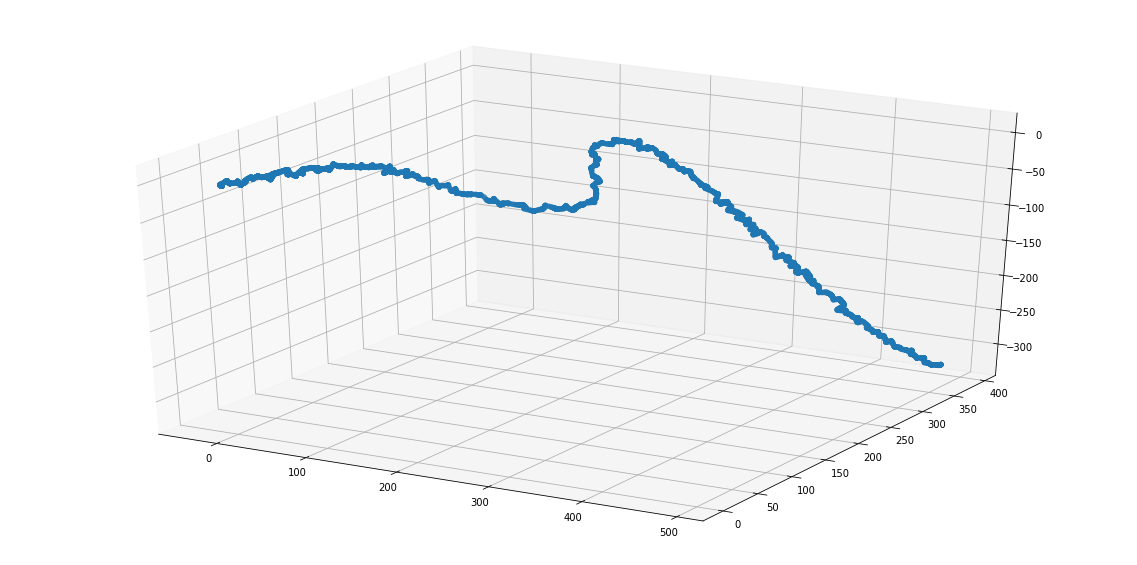

In [329]:
fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.scatter(x0, x1, x2)

plt.show()

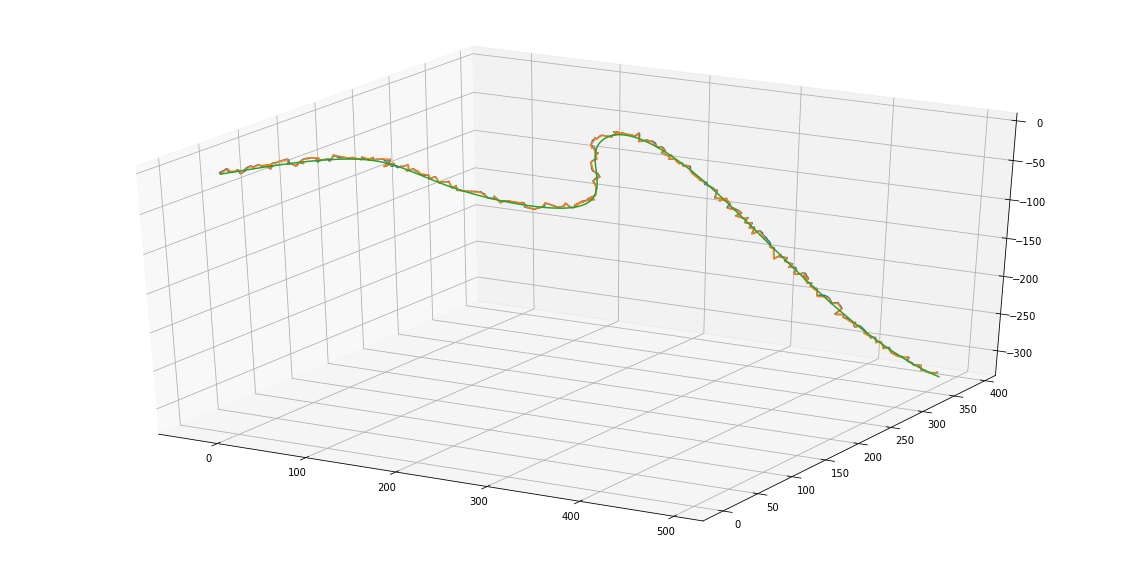

In [336]:
# print(x0)
# print(x1)
# print(x2)
# print(mx[0:5])
# print(my[0:5])
# print(mz[0:5])

kx = mx[0:ri]
ky = my[0:ri]
kz = mz[0:ri]

fig = plt.figure(figsize=(20,10))
axplot = fig.gca(projection='3d')
axplot.plot( x0, x1, x2)
axplot.plot( kx, ky, kz)
axplot.plot(real_mx, real_my, real_mz)
# axplot.plot(x0, x1, x2, label='trajectory')
# axplot.plot(h0, h1, h2)
# axplot.plot(kx, ky, kz)


# axplot.legend()

plt.show()




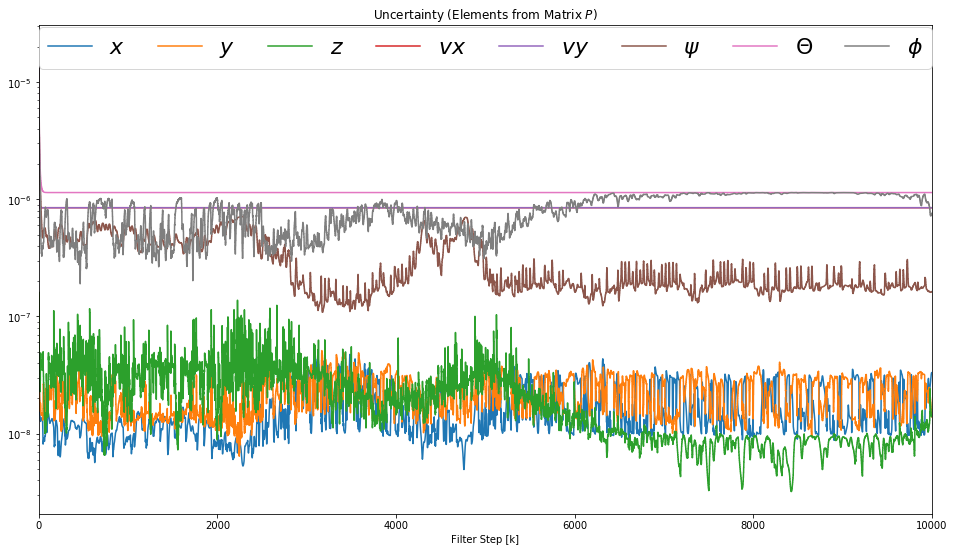

In [331]:
m = ri 
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),P0, label='$x$')
plt.step(range(m),P1, label='$y$')
plt.step(range(m),P2, label='$z$')
plt.step(range(m),P3, label='$vx$')
plt.step(range(m),P4, label='$vy$')
plt.step(range(m),P5, label='$\psi$')
plt.step(range(m),P6, label='$\Theta$')
plt.step(range(m),P7, label='$\phi$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,ri)
plt.title('Uncertainty (Elements from Matrix $P$)')
#plt.legend(loc='best',prop={'size':22})
plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
       ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')

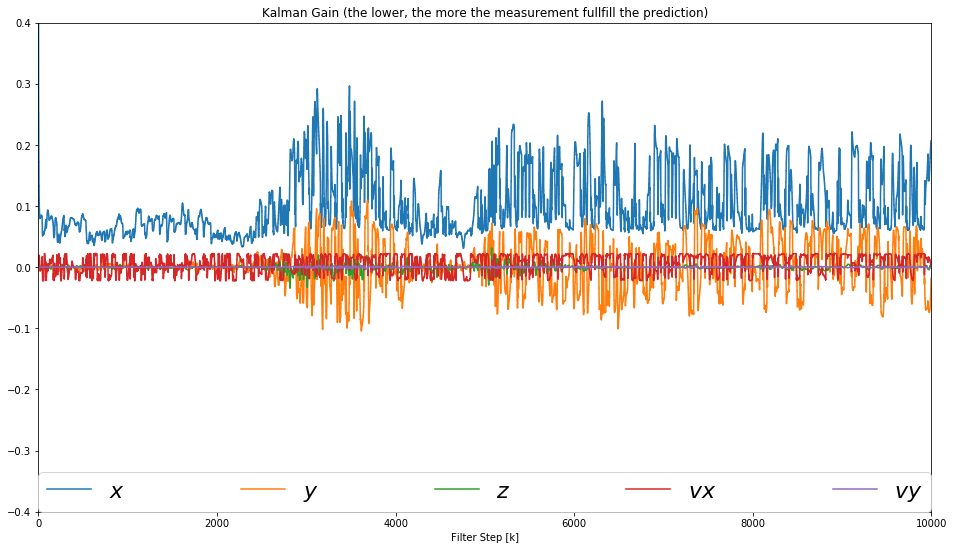

In [332]:
fig = plt.figure(figsize=(16,9))
plt.step(range(ri),K0, label='$x$')
plt.step(range(ri),K1, label='$y$')
plt.step(range(ri),K2, label='$z$')
plt.step(range(ri),K3, label='$vx$')
plt.step(range(ri),K4, label='$vy$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,ri)
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
#plt.legend(prop={'size':18})
plt.legend(bbox_to_anchor=(0., 0., 1., .102), loc=3,
       ncol=5, mode="expand", borderaxespad=0.,prop={'size':22})
plt.ylim([-0.4,0.4])

In [333]:
## Process Noise Covarance Matrix Q

In [334]:
CTEy = (x1 - real_my)
CTEx = (x0 - real_mx)
CTEz = (x2 - real_mz)

sCTEy = np.sum(CTEy**2)
sCTEx = np.sum(CTEx**2)
sCTEz = np.sum(CTEz**2)

Text(0,0.5,'CTE [m]')

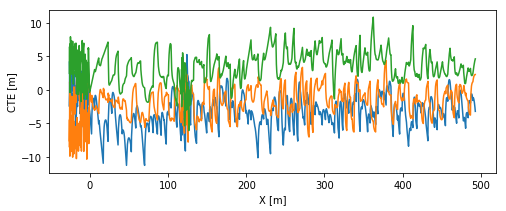

In [335]:

fig = plt.figure(figsize=(8,3))
plt.plot(real_mx, CTEx, label='$CTE_x$, $\Sigma(CTE_x^2)$=%.0f$m^2$' % sCTEx)
plt.plot(real_mx, CTEy, label='$CTE_y$, $\Sigma(CTE_y^2)$=%.0f$m^2$' % sCTEy)
plt.plot(real_mx, CTEz, label='$CTE_z$, $\Sigma(CTE_z^2)$=%.0f$m^2$' % sCTEz)

plt.xlabel('X [m]')
plt.ylabel('CTE [m]')

# plt.title('$CTE$ of Position Estimation with static $R$')
# plt.legend(loc='best')
# plt.axis('equal')
# plt.xlim([-10, np.max(xout)+10])
# plt.ylim(-80, 40)

# # Annotations
# bbox_props = dict(boxstyle="square,pad=0.9", fc="k", ec="w", lw=2)
# t = plt.text(160, -30, "B", ha="left", va="center", rotation=0,
#             size=16, color='grey',
#             bbox=bbox_props)

# plt.annotate('stop', xy=(30, -20), xytext=(60, -50), fontsize=16,
#             arrowprops=dict(facecolor='k', shrink=0.05), ha='center',
#             )

# plt.legend(loc='lower right')

# plt.tight_layout()
